\begin{tabular}{rrrrrr}
\toprule
Writers & Blob Size (Bytes) & C++ Avg. Latency (ns) & Python Avg. Latency (ns) & C++ Throughput (Gbps) & Python Throughput (Gbps) \\
\midrule
1 & 100 & 119.4 & 1,901.8 & 6.7 & 0.4 \\
1 & 1,000 & 453.3 & 1,262.0 & 17.6 & 6.3 \\
1 & 10,000 & 4,187.4 & 5,419.5 & 19.1 & 14.8 \\
1 & 50,000 & 20,720.0 & 22,961.3 & 19.3 & 17.4 \\
2 & 100 & 304.5 & 1,700.2 & 2.6 & 0.5 \\
2 & 1,000 & 1,075.0 & 1,943.4 & 7.4 & 4.1 \\
2 & 10,000 & 6,172.5 & 7,103.1 & 13.0 & 11.3 \\
2 & 50,000 & 20,569.8 & 22,625.0 & 19.4 & 17.7 \\
4 & 100 & 332.1 & 1,414.4 & 2.4 & 0.6 \\
4 & 1,000 & 1,108.0 & 1,930.2 & 7.2 & 4.1 \\
4 & 10,000 & 4,116.9 & 5,708.7 & 19.4 & 14.0 \\
4 & 50,000 & 14,561.6 & 23,540.0 & 27.5 & 17.0 \\
8 & 100 & 376.2 & 1,601.2 & 2.1 & 0.5 \\
8 & 1,000 & 1,329.0 & 1,883.8 & 6.0 & 4.2 \\
8 & 10,000 & 4,313.3 & 11,071.5 & 18.5 & 7.2 \\
8 & 50,000 & 16,425.8 & 53,903.3 & 24.4 & 7.4 \\
16 & 100 & 403.3 & 1,778.0 & 2.0 & 0.4 \\
16 & 1,000 & 1,202.5 & 17,073.5 & 6.7 & 0.5 \\
16

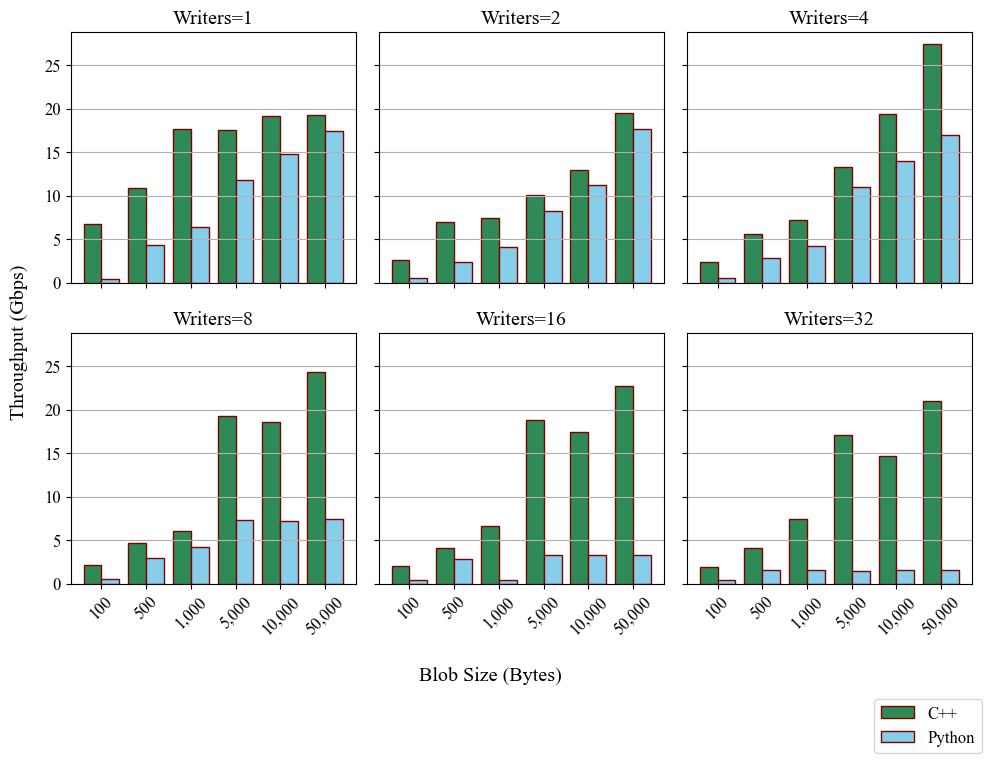

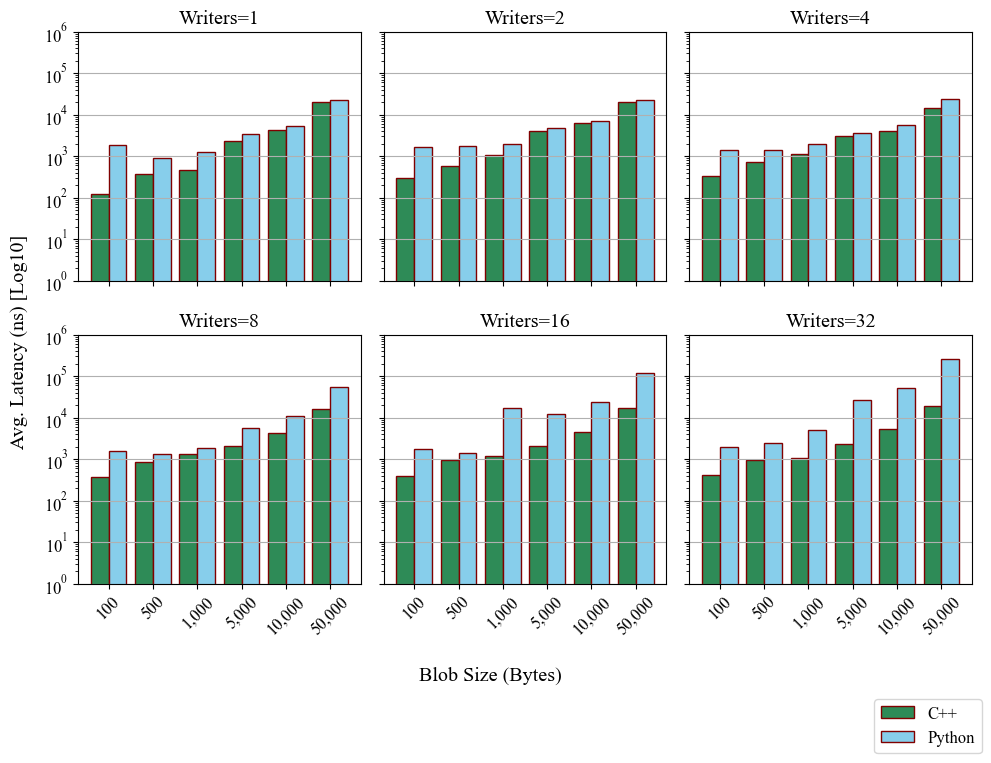

In [35]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"
pd.set_option('mode.chained_assignment', None)

G = 1000000000
M = 1000000

def update_df(df):
    df['avg_latency'] = (df['Time']/df['Entries'])
    df['Gbs'] = df['Entries']*8*df['Size']/G
    df['Gbps'] = df['Gbs'] / (df['Time'] / G)
    
def create_plots(df1, df2, ytitle, val_col, filename, logscale = False, ylim = None):
    
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,7))
    writers = list(set(df1['Writers']))
    writers.sort()

    c = 0
    for i in range(2):
        for j in range(3):
            sub = ax[i][j]
            w = writers[c]
            sub_df1 = df1[df1['Writers'] == w]
            sub_df2 = df2[df2['Writers'] == w]
            labels = ['{:,}'.format(value) for value in sub_df1['Size']]
            x = np.arange(len(labels))
            sub.bar(x - 0.2 ,list(sub_df1[val_col].values), color ='seagreen', width = 0.4, label='C++', edgecolor='maroon')
            sub.bar(x + 0.2 ,list(sub_df2[val_col].values), color ='skyblue', width = 0.4, label='Python', edgecolor='maroon')
            sub.set_xticks(x)
            sub.set_title(f"Writers={w}")
            if logscale:
                sub.set_yscale('log')
            if ylim:
                sub.set_ylim(ylim[0], ylim[1])
            sub.set_xticklabels(labels, rotation=45)
            sub.grid(axis='y')
            c+=1 

    fig.supxlabel('Blob Size (Bytes)')
    fig.supylabel(ytitle)
    handles, labs = ax[0][0].get_legend_handles_labels()
    fig.legend(handles, labs, loc='lower right', bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure)
    
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

cpp_df = pd.read_csv("../test-results/vm/local/pc_test.csv", compression='gzip')
py_df = pd.read_csv("../test-results/vm/local/py_pc_test.csv")
update_df(cpp_df)
update_df(py_df)

create_plots(cpp_df, py_df, 'Throughput (Gbps)', 'Gbps', "../test-results/pc_test_throughput.png")
create_plots(cpp_df, py_df, 'Avg. Latency (ns) [Log10]', 'avg_latency', "../test-results/pc_test_latency.png", True,ylim=[1, 10**6])


columns = ['Entries', 'Writers', 'Size', 'avg_latency', 'Gbps']
cpp_df = cpp_df[columns]
py_df = py_df[columns]
py_df.rename(columns={'avg_latency': 'py_avg_latency', 'Gbps': 'py_Gbps'}, inplace=True)


py_df.set_index(['Entries', 'Writers', 'Size'], inplace=True)
cpp_df.set_index(['Entries', 'Writers', 'Size'], inplace=True)
out_df = cpp_df.join(py_df).reset_index()



table_bytes = [100, 1000, 10000, 50000]
out_df = out_df[out_df['Size'].isin(table_bytes)]

out_df = out_df[["Writers", "Size", "avg_latency", "py_avg_latency", "Gbps", "py_Gbps"]]
out_df.rename(columns={"Size": "Blob Size (Bytes)", "avg_latency": "C++ Avg. Latency (ns)",
                      "py_avg_latency": "Python Avg. Latency (ns)", 
                      "Gbps": "C++ Throughput (Gbps)", "py_Gbps": "Python Throughput (Gbps)"}, inplace=True)
print(out_df.to_latex(index=False, float_format="{:,.1f}".format, formatters={"Blob Size (Bytes)": "{:,}".format}))
